# Look at the overview scans
Let's see what we did there.

In [1]:
import platform
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches
import seaborn
import imageio
import pandas
import numpy
from tqdm import tqdm_notebook
from itkwidgets import view  # 3d viewer
import skimage
import dask
import dask.array as da
import dask_image.imread
from distributed import Client
client = Client(processes=False,
#                 n_workers=32,
#                 silence_logs=True
               )
# Then go to http://localhost:8787/status
from numcodecs import Blosc


Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.


In [2]:
client.scheduler_info()['services']

{'dashboard': 43977}

In [3]:
# # Ignore warnings in the notebook
# import warnings
# warnings.filterwarnings("ignore")

In [4]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit

In [5]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [6]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [7]:
# Different locations if running either on Linux or Windows
FastSSD = True
# to speed things up significantly
if 'debian' in platform.dist():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        BasePath = os.path.join('S:\\')
Root = os.path.join(BasePath, 'Tuebingen', 'Overview')
print('We are loading all the data from %s' % Root)

We are loading all the data from /media/habi/Fast_SSD/Tuebingen/Overview


dist() and linux_distribution() functions are deprecated in Python 3.5


In [8]:
def get_experiment(i):
    '''Categorize  into 'N' or 'OP' '''
    if 'N' in i:
        return 'N'
    if 'OP' in i:
        return 'OP'

In [9]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [10]:
def get_numberofreconstructions(logfile):
    """Get the number of reconstructions """
    with open(logfile, 'r') as f:
        for line in f:
            if 'Sections Count' in line:
                numrec = int(line.split('=')[1])
    return(numrec)

In [11]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [12]:
# Get all folders
Data['Folder'] = glob.glob(os.path.join(Root, '*'))

In [13]:
# Get rid of all non-folders
for c, i in Data.iterrows():
    if not os.path.isdir(i.Folder):
        Data.drop([c], inplace=True)

In [14]:
try:
    Data['Folder'][0]
except IndexError:
    print(10 * '\n')
    print('Please mount the Fast SSD!')
    print(10 * '\n')

In [15]:
Data['Sample'] = [os.path.basename(f) for f in Data['Folder']]
Data['Experiment'] = [get_experiment(s) for s in Data['Sample']]
Data['SampleNameLength'] = [len(r) for r in Data['Sample']]

In [16]:
Data['LogFile'] = [sorted(glob.glob(os.path.join(f, 'proj', '*.log')))[0] for f in Data['Folder']]
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]
Data['NumRec'] = [get_numberofreconstructions(log) for log in Data['LogFile']]

In [17]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f, 'rec', '*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [18]:
# Display some info
for c, row in Data.iterrows():
    print('%02s/%s: %s should have %05s reconstructions '
          'according to %s' % (c + 1,
                               len(Data),
                               row['Sample'].rjust(Data['SampleNameLength'].max()),
                               row['NumRec'],
                               os.path.basename(row['LogFile'])))
    print('%11s actually has %04s reconstructions in %s/%s' % (row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                               row['Number of reconstructions'],
                                                               os.path.basename(row['Folder']),
                                                               'rec'))

 1/14:  04N should have  1767 reconstructions according to 04N.log
        04N actually has 1767 reconstructions in 04N/rec
 2/14: 04OP should have  1606 reconstructions according to 04OP.log
       04OP actually has 1606 reconstructions in 04OP/rec
 3/14:  07N should have  1598 reconstructions according to 07N.log
        07N actually has 1598 reconstructions in 07N/rec
 4/14: 07OP should have  1753 reconstructions according to 07OP.log
       07OP actually has 1753 reconstructions in 07OP/rec
 5/14:  10N should have  1948 reconstructions according to 10N.log
        10N actually has 1948 reconstructions in 10N/rec
 6/14: 10OP should have  2014 reconstructions according to 10OP.log
       10OP actually has 2014 reconstructions in 10OP/rec
 7/14:  14N should have  1574 reconstructions according to 14N.log
        14N actually has 1574 reconstructions in 14N/rec
 8/14: 14OP should have  1746 reconstructions according to 14OP.log
       14OP actually has 1746 reconstructions in 14OP/rec


In [19]:
# Some datasets might not be reconstructed yet.
# Drop those, based on https://stackoverflow.com/a/27360130/323100
Data.drop(Data[Data['Number of reconstructions'] < 1].index, inplace=True)
# Reset index, so we can still count like we used to
Data.reset_index(inplace=True)

In [20]:
# Convert all reconstructions into a DASK array and save them to disk
# Partially based on http://stackoverflow.com/a/39195332/323100
# and on /LungMetastasis/HighResolutionScanAnalysis.ipynb
Data['OutputNameRec'] = [os.path.join(f, sample + '_rec.zarr') for f, sample in zip(Data.Folder, Data.Sample)]
Reconstructions = [numpy.nan for file in Data['OutputNameRec']]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameRec']):
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameRec'][len(Root):]))
    else:
        print('%2s/%s: Reading %s reconstructions and saving to %s' % (c + 1,
                                                                       len(Data),
                                                                       row['Number of reconstructions'],
                                                                       row['OutputNameRec'][len(Root):]))
        Reconstructions = dask_image.imread.imread(os.path.join(row['Folder'],
                                                                'rec',
                                                                '*.png'))
        Reconstructions.to_zarr(row['OutputNameRec'],
                                overwrite=True,
                                compressor=Blosc(cname='zstd',
                                                 clevel=3,
                                                 shuffle=Blosc.BITSHUFFLE))           

 1/14: Already saved to /04N/04N_rec.zarr
 2/14: Already saved to /04OP/04OP_rec.zarr
 3/14: Already saved to /07N/07N_rec.zarr
 4/14: Already saved to /07OP/07OP_rec.zarr
 5/14: Already saved to /10N/10N_rec.zarr
 6/14: Already saved to /10OP/10OP_rec.zarr
 7/14: Already saved to /14N/14N_rec.zarr
 8/14: Already saved to /14OP/14OP_rec.zarr
 9/14: Already saved to /15N/15N_rec.zarr
10/14: Already saved to /15OP/15OP_rec.zarr
11/14: Already saved to /19N/19N_rec.zarr
12/14: Already saved to /19OP/19OP_rec.zarr
13/14: Already saved to /22N/22N_rec.zarr
14/14: Already saved to /22OP/22OP_rec.zarr


In [21]:
Reconstructions = [numpy.nan for file in Data['OutputNameRec']]
for c, row in Data.iterrows():
    Reconstructions[c] =  dask.array.from_zarr(row['OutputNameRec'])

In [22]:
# Reconstructions[0]

In [23]:
# How big are the datasets?
Data['Size'] = [numpy.shape(rec) for rec in Reconstructions]

In [24]:
# The three cardinal directions
directions = ['Axial', 'Sagittal', 'Coronal']

In [25]:
# DASK
# Read or calculate the middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_' + direction] = [None] * len(Reconstructions)
for c, row in tqdm_notebook(Data.iterrows(), desc='Middle images', total=len(Data)):
    for d, direction in tqdm_notebook(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'],
                                   '%s.Middle.%s.png' % (row['Sample'],
                                                         direction))
        if os.path.exists(outfilepath):
            Data.at[c,'Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'Mid_' + direction] = Reconstructions[c][Data['Size'][c][0]//2].compute()
            if 'Sagittal' in direction:
                Data.at[c,'Mid_' + direction] = Reconstructions[c][:,Data['Size'][c][1]//2,:].compute()
            if 'Coronal' in direction:
                Data.at[c,'Mid_' + direction] = Reconstructions[c][:,:,Data['Size'][c][2]//2].compute()
            # Save the calculated 'direction' view out
            # Dask only calculates/reads the images here at this point...
            imageio.imwrite(outfilepath, Data.at[c,'Mid_' + direction])

In [26]:
# # Show middle slices
# for c, row in Data.iterrows():
#     for d, direction in enumerate(directions):
#         plt.subplot(1, 3, d + 1)
#         plt.imshow(row['Mid_' + direction])
#         plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
#         plt.title('%s/%s: %s, %s' % (c + 1,
#                                      len(Data),
#                                      row['Sample'],
#                                      direction + ' Middle slice'))
#         plt.axis('off')
#     plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.MiddleSlices.png'),
#                 bbox_inches='tight')
#     plt.show()

In [27]:
# DASK
# Read or calculate MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(Reconstructions)
for c, row in tqdm_notebook(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in tqdm_notebook(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'],
                                   '%s.MIP.%s.png' % (row['Sample'],
                                                      direction))
        if os.path.exists(outfilepath):
            Data.at[c,'MIP_' + direction] = imageio.imread(outfilepath)
        else:
            # Keep *this* reconstruction in RAM for a bit
            img = Reconstructions[c].persist()
            # Generate MIP
            Data.at[c,'MIP_' + direction] = img.max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath,
                            Data.at[c,'MIP_' + direction])

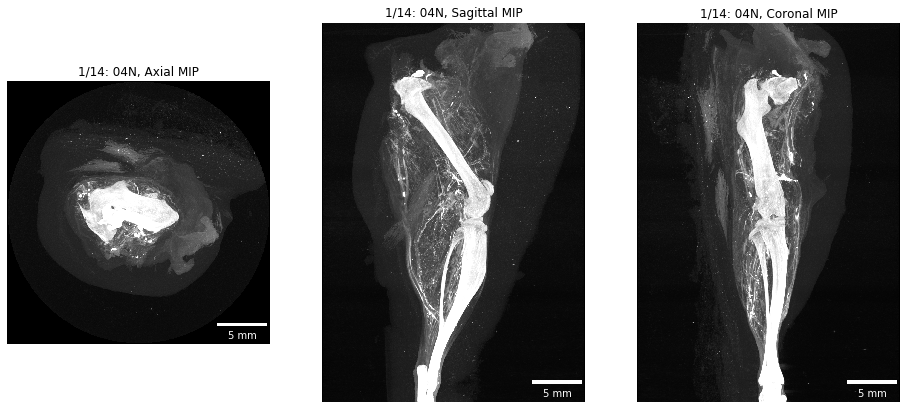

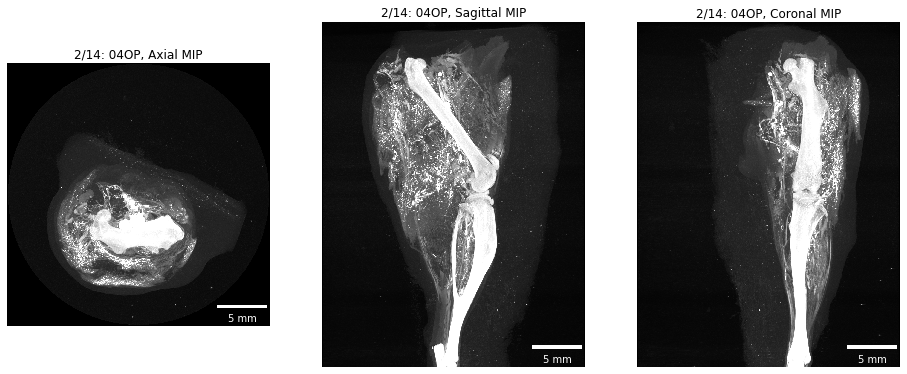

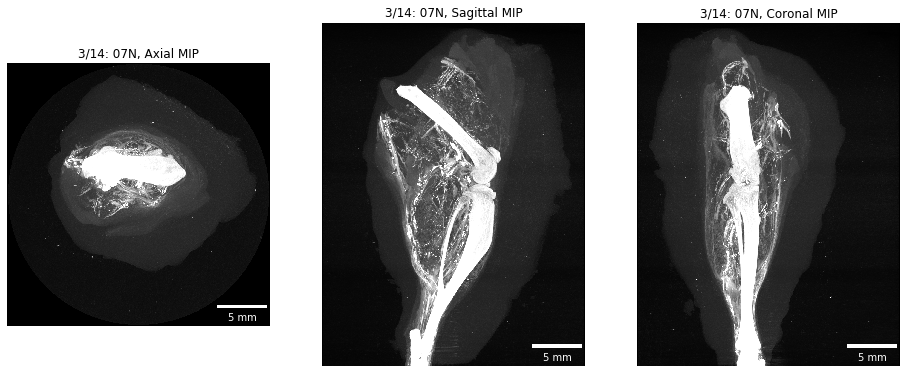

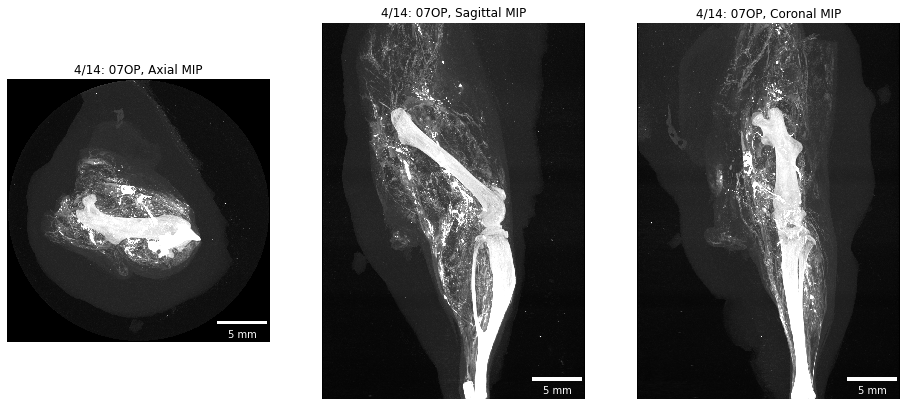

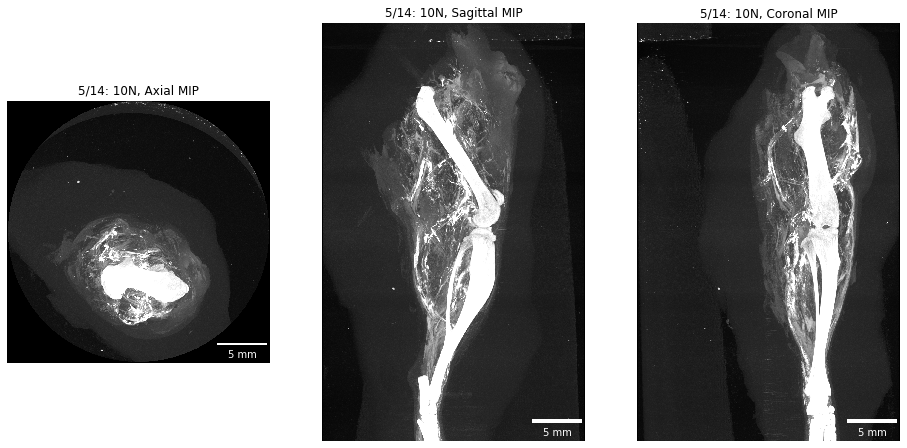

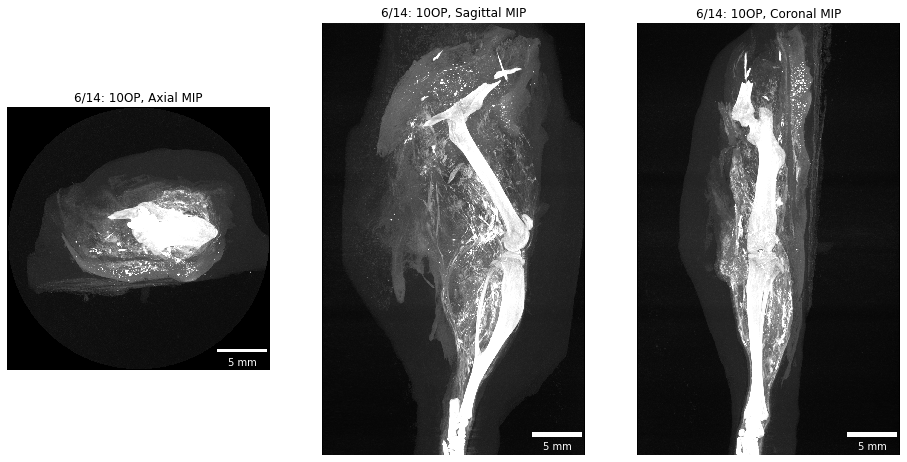

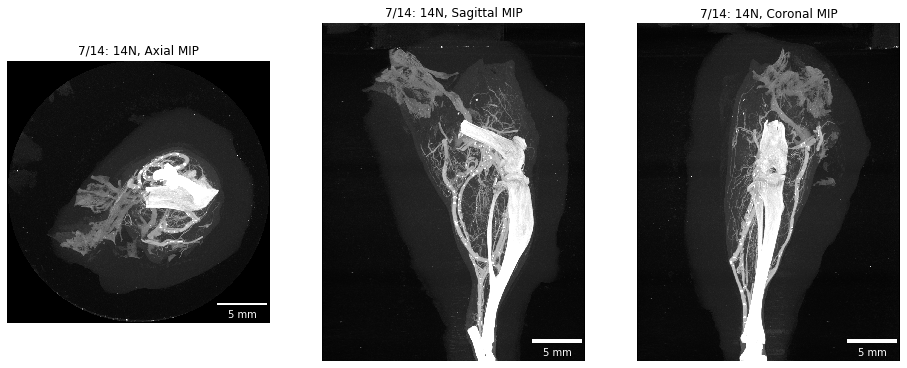

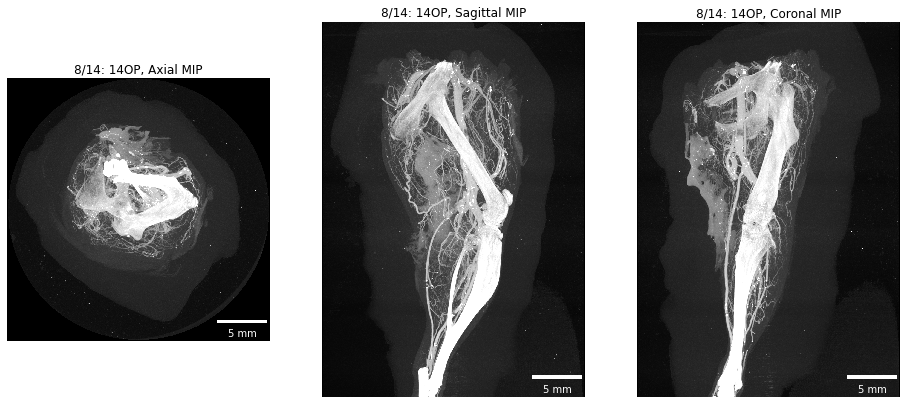

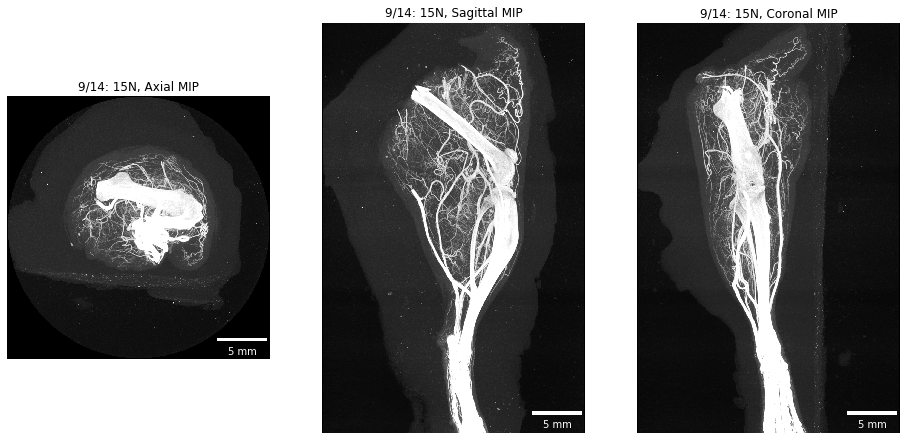

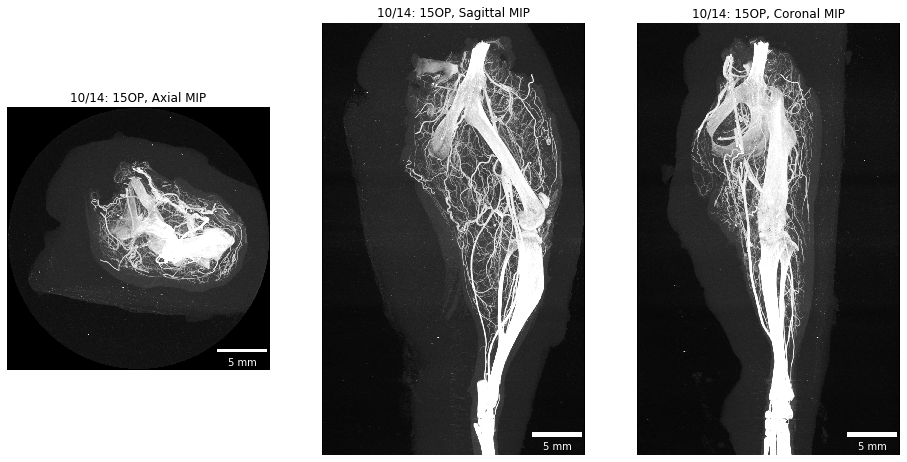

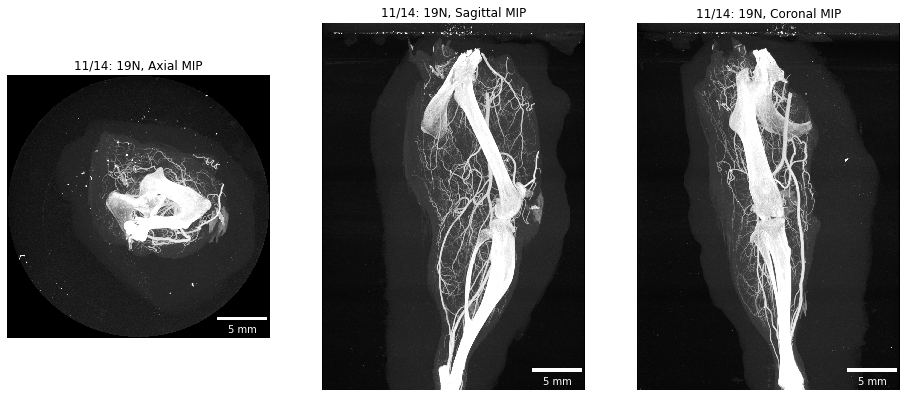

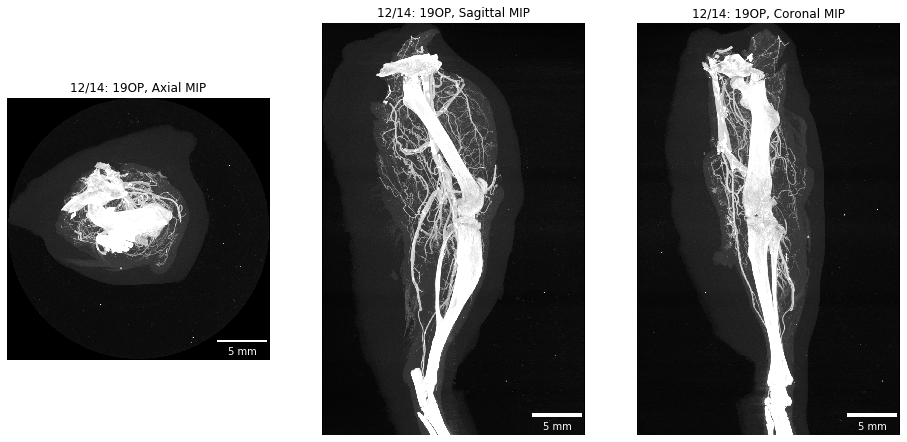

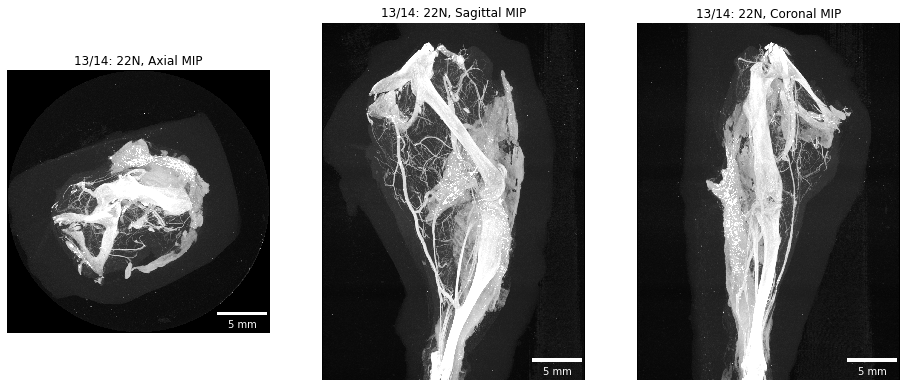

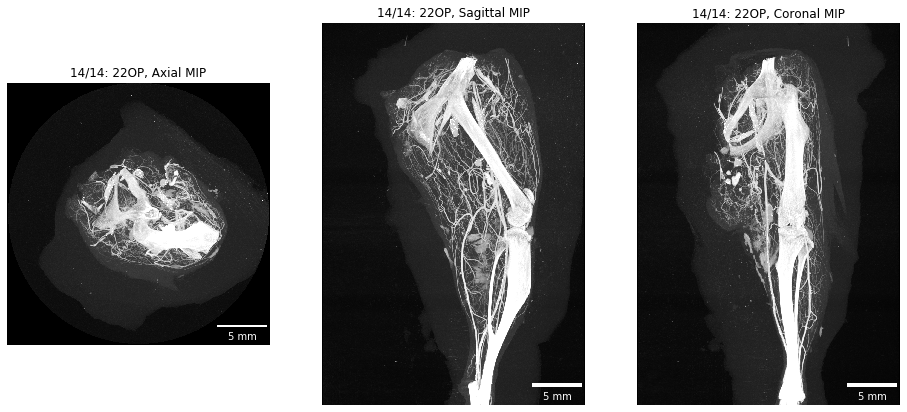

In [28]:
# Show MIP slices
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['MIP_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        plt.title('%s/%s: %s, %s' % (c + 1,
                                     len(Data),
                                     row['Sample'],
                                     direction + ' MIP'))
        plt.axis('off')
    plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.MIPs.png'),
                bbox_inches='tight')
    plt.show()

Axial


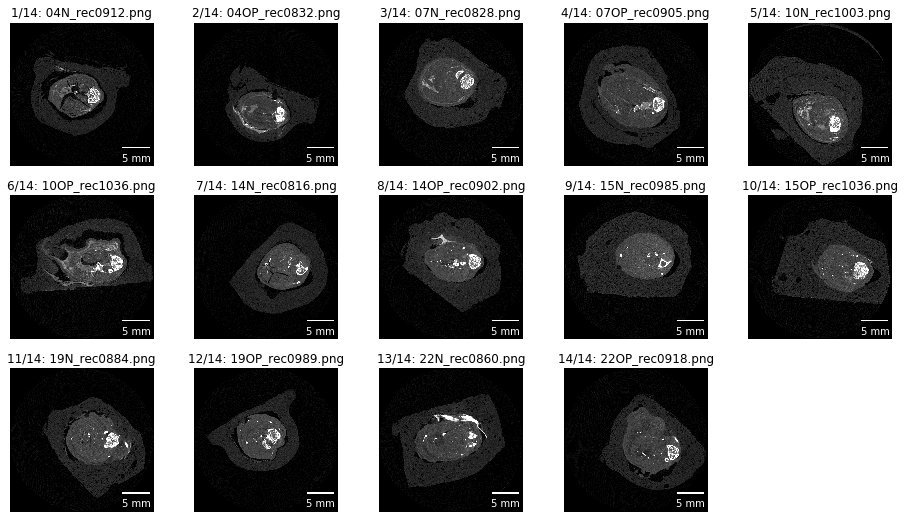

Sagittal


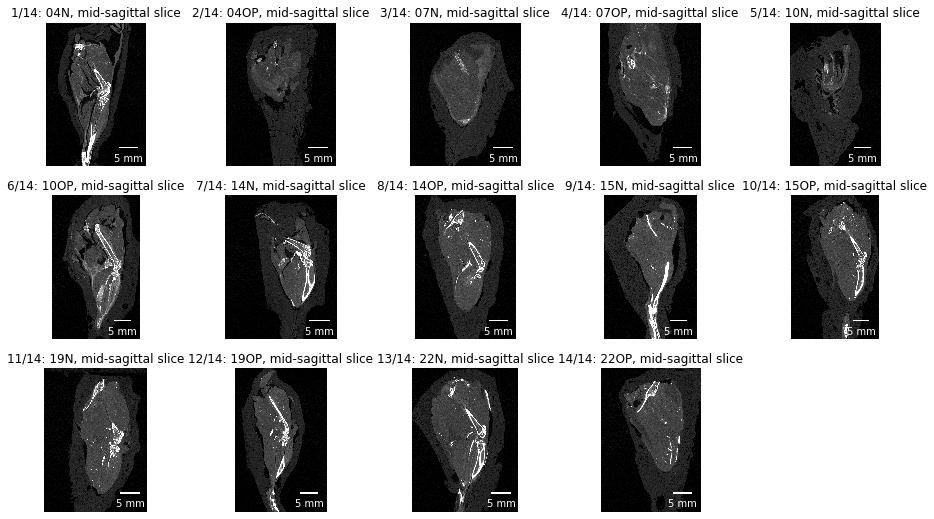

Coronal


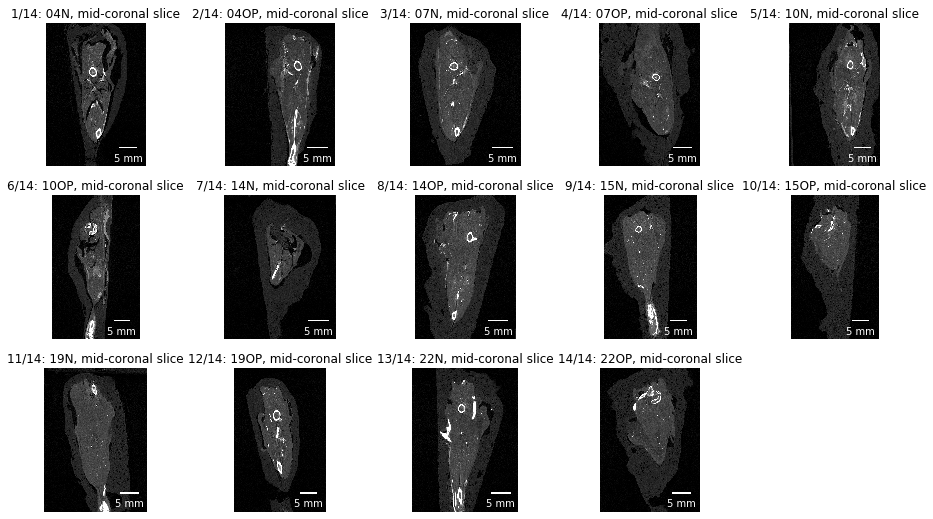

In [29]:
# Show middle slices together
for d, direction in enumerate(directions):
    print(direction)
    for c, row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['Mid_' + direction],
                   vmax=row['Mid_' + direction].max() * .618)
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        if 'xial' in direction:
            recname = os.path.basename(row['Reconstructions'][row['Number of reconstructions'] // 2]).replace('0000',
                                                                                                              '')
            plt.title('%s/%s: %s' % (c + 1,
                                     len(Data),
                                     recname))
        else:
            plt.title('%s/%s: %s, mid-%s slice' % (c + 1,
                                                   len(Data),
                                                   row['Sample'],
                                                   direction.lower()))
        plt.axis('off')
        plt.savefig(os.path.join(Root, 'MiddleSlices.' + direction + '.png'),
                    bbox_inches='tight')
    plt.show()

Axial


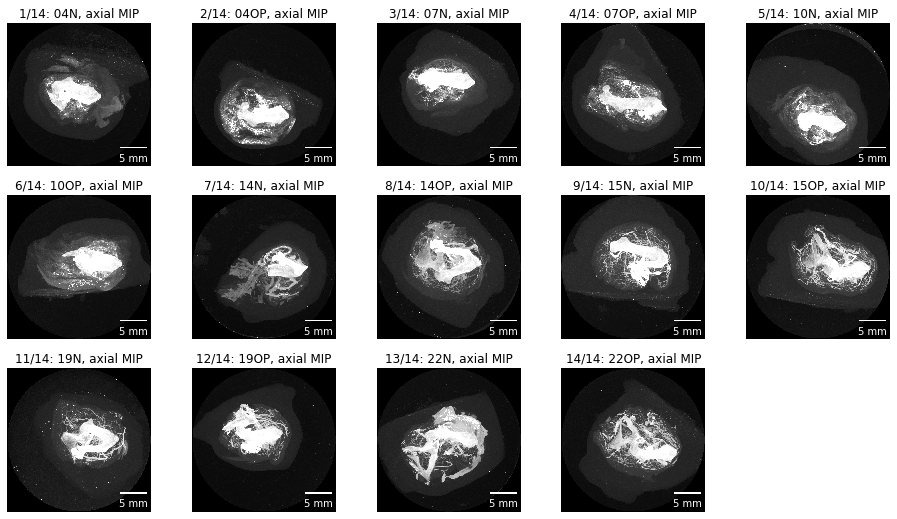

Sagittal


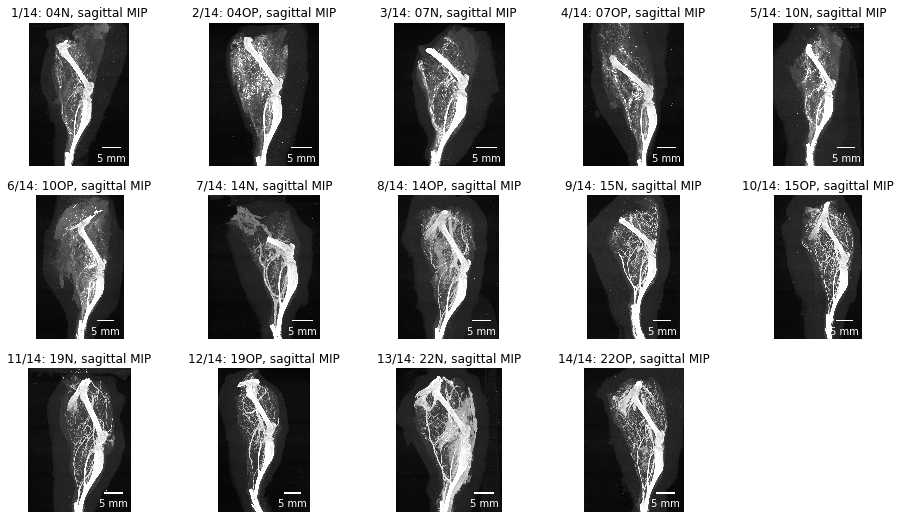

Coronal


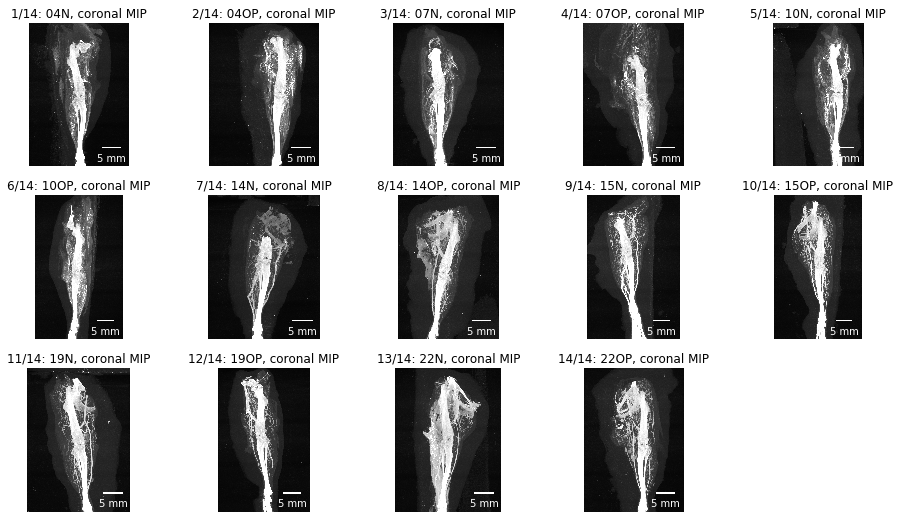

In [30]:
# Show MIPs together
for d, direction in enumerate(directions):
    print(direction)
    for c, row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['MIP_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        plt.title('%s/%s: %s, %s MIP' % (c + 1,
                                         len(Data),
                                         row['Sample'],
                                         direction.lower()))
        plt.axis('off')
        plt.savefig(os.path.join(Root, 'MIPs.' + direction + '.png'),
                    bbox_inches='tight')
    plt.show()

In [31]:
# Save out the single MIPs to disk
for c, row in tqdm_notebook(Data.iterrows(), desc='Writing MIPs', total=len(Data)):
    for direction in tqdm_notebook(directions, desc=row['Sample'], leave=False):
        outfilepath = os.path.join(row['Folder'], '%s.MIP.%s.png' % (row['Sample'], direction))
        if not os.path.exists(outfilepath):
            imageio.imwrite(outfilepath, row['MIP_' + direction])

In [32]:
# Save mean and STD of gray values, which we can use for getting an overview of the image data
Data['GrayValueMean'] = [rec.mean().compute() for rec in Reconstructions]

In [33]:
Data['GrayValueSTD'] = [rec.std().compute() for rec in Reconstructions]

In [34]:
# Save out the dataframe to disk, so we can use it later in another notebook
Data.to_pickle(os.path.join(Root, 'TuebingenDataframe.pkl'))

In [35]:
print('Done')

Done
